# TensorFlow api-based neural net.

In this workbook we build a neural network to predict survival. The two common frameworks used for neural networks (as of 2020) are TensorFlow and PyTorch. Both are excellent frameworks. TensorFlow frequently requires fewer lines of code, but PyTorch is more natively Python in its syntax, and also allows for easier debugging as the model may be interrupted, with a breakpoint, and debugged as necessary. This makes PyTorch particularly suitable for research and experimentation. A disadvantage of using PyTorch is that, compared with TensorFlow, there are fewer training materials and examples available.

Here we use 'keras' which is integrated into TensorFlow and makes it simpler and faster to build TensorFlow models.

Both TensorFlow and PyTorch allow the neural network to be trained on a GPU, which is beneficial for large neural networks (especially those processing image, sound or free-text data). In order to lever the benefits of GPU (which perform many calculations simultaneously), data is grouped into batches. These batches are presented to the CPU in a single object called a Tensor (a multi-dimensional array). 

To install TensorFlow as a new environment in Anaconda type the following from a terminal
`conda create -n tensorflow tensorflow && conda install -n tensorflow scikit-learn pandas matplotlib`

Or PIP install with:

`pip install --upgrade pip`
`pip install tensorflow`

The latest release of TensorFlow supports CPU and GPU, If using an older installation then use `tensorflow-gpu` in place of `tensorflow` to install a gpu-capable version of TensorFlow.

Then from Anaconda Navigator, select the TensorFlow environment.

There are two versions of this workbook. This version uses a simpler form of constructing the neural network. The alternative version uses an api-based method which offers some more flexibility (but at the cost of a little simplicity). It is recommended to work through both methods.

It is not the intention here to describe neural networks in any detail, but rather give some introductory code to using a neural network for a classification problem. For an introduction to neural networks see: https://en.wikipedia.org/wiki/Artificial_neural_network

The code for PyTorch here keeps all calculations on the CPU rather than passing to a GPU (if you have one). Running neural networks on CPUs is fine for structured data such as our Titanic data. GPUs come in to their own for unstructured data like images, sound clips, or free text.

The training process of a neural network consists of three general phases which are repeated across all the data. All of the data is passed through the network multiple times (the number of iterations, which may be as few as 3-5 or may be 100+). The three phases are:

* Pass training X data to the network and predict y
* Calculate the 'loss' (error) between the predicted and observed (actual) values of y
* Adjust the network a little (as defined by the learning rate) so that the error is reduced. The correction of the network is performed by PyTorch or TensorFlow using a technique called 'back-propagation'.

The learning is repeated until maximum accuracy is achieved (but keep an eye on accuracy of test data as well as training data as the network may develop significant over-fitting to training data unless steps are taken to offset the potential for over-fitting, such as use of 'drop-out' layers described below).

Note: Neural Networks are most often used for complex unstructured data. For structured data, other techniques, such as Random Forest,s may frequently be preferred.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

2021-10-09 22:55:18.533874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Download data if not previously downloaded

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to calculate accuracy measurements

In [4]:
import numpy as np

def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [6]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net

Here we use the api-based method to set up a TensorFlow neural network. This method allows us
to more flexibly define the inputs for each layer, rather than assuming there is a simple sequence as with the Sequential method.

We will put construction of the neural net into a separate function.

The neural net is a relatively simple network. The inputs are connected to two hidden layers (of 240 and 50 nodes) before being connected to two output nodes corresponding to each class (died and survived). It also contains some useful additions (batch normalisation and dropout) as described below.
The layers of the network are:

1) An input layer (which does need to be defined)

2) A fully-connected (dense) layer.This is defined by the number of inputs (the number of input features) and the number of outputs. We will expand out feature data set up to 240 outputs. The output of the layer uses ReLU (rectified linear unit) activation. ReLU activation is most common for the inner layers of a neural network. Negative input values are set to zero. Positive input values are left unchanged.

3) A batch normalisation layer. This is not usually used for small models, but can increase the speed of training for larger models. It is added here as an example of how to include it (in large models all dense layers would be followed by a batch normalisation layer). The layer definition includes the number of inputs to normalise. 

4) A dropout layer. This layer randomly sets outputs from the preceding layer to zero during training (a different set of outputs is zeroed for each training iteration). This helps prevent over-fitting of the model to the training data. Typically between 0.1 and 0.3 outputs are set to zero (p=0.1 means 10% of outputs are set to zero).

5) A second fully connected layer which reduces the network down to 50 nodes. This again uses ReLU activation and is followed by batch normalisation, and dropout layers.

6) A final fully connected linear layer of one nodes (more nodes could be used for more classes, in which case use softmax activation and categorical_crossentropy in the loss function). The output of the net is the probability of surviving (usually a probability of >= 0.5 will be classes as ‘survived’).

In [7]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Define layers
    inputs = layers.Input(shape=number_features)
    dense_1 = layers.Dense(240, activation='relu')(inputs)
    norm_1 = layers.BatchNormalization()(dense_1)
    dropout_1 = layers.Dropout(0.25)(norm_1)
    dense_2 = layers.Dense(50, activation='relu')(dropout_1)
    outputs = layers.Dense(1, activation='sigmoid')(dense_2)
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net


## Show summary of the model structure

Here we will create a model with 10 input features and show the structure of the model as  atable and as a graph.

In [8]:
model = make_net(10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 240)               2640      
_________________________________________________________________
batch_normalization (BatchNo (None, 240)               960       
_________________________________________________________________
dropout (Dropout)            (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,701
Trainable params: 15,221
Non-trainable params: 480
_______________________________________________________

2021-10-09 22:55:19.818860: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 22:55:19.819768: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-09 22:55:19.898171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 22:55:19.898539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-10-09 22:55:19.898573: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-09 22:55:19.900196: I tensorflow/stream_executor/platform

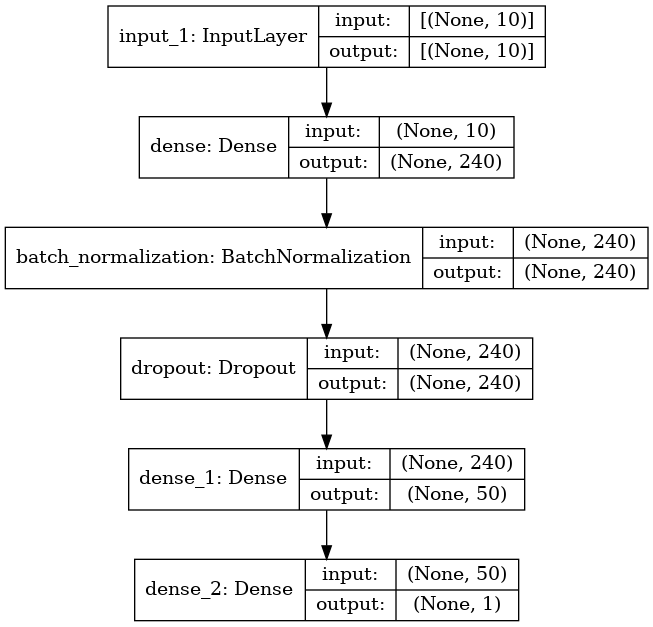

In [9]:
# If necessary pip or conda install pydot and graphviz
keras.utils.plot_model(model, "titanic_tf_model.png", show_shapes=True)

## Run the model with k-fold validation

In [10]:
# Set up lists to hold results
training_acc_results = []
test_acc_results = []

# Set up splits
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
k_counter = 0

for train_index, test_index in skf.split(X_np, y_np):
    k_counter +=1
    print('K_fold {}'.format(k_counter))
    
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Scale X data
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]
    model = make_net(number_features)
    
    ### Train model
    model.fit(X_train_sc,
             y_train,
             epochs=150,
             batch_size=512,
             verbose=0)
            
    ### Test model (print results for each k-fold iteration)
    probability = model.predict(X_train_sc)
    y_pred_train = probability >= 0.5
    y_pred_train = y_pred_train.flatten()
    accuracy_train = np.mean(y_pred_train == y_train)
    training_acc_results.append(accuracy_train)

    probability = model.predict(X_test_sc)
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten()
    accuracy_test = np.mean(y_pred_test == y_test)
    test_acc_results.append(accuracy_test)

K_fold 1


2021-10-09 22:55:20.653991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-09 22:55:20.671058: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
2021-10-09 22:55:21.170073: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


K_fold 2
K_fold 3
K_fold 4
K_fold 5


## Show training and test results

In [ ]:
# Show individual accuracies on training data
training_acc_results

In [ ]:
# Show individual accuracies on test data
test_acc_results

In [ ]:
# Get mean results
mean_training = np.mean(training_acc_results)
mean_test = np.mean(test_acc_results)

# Display each to three decimal places
print ('{0:.3f}, {1:.3}'.format(mean_training,mean_test))

## Plot results: Box Plot

Box plots show median (orange line), the second and third quartiles (the box), the range (excluding outliers), and any outliers as 'whisker' points. Outliers, by convention, are conisiered to be any points outside of the quartiles +/- 1.5 times the interquartile range. The limit for outliers may be changed using the optional `whis` argument in the boxplot.

Medians tend to be an easy reliable guide to the centre of a distribution (i.e. look at the medians to see whether a fit is improving or not, but also look at the box plot to see how much variability there is).

Test sets tend to be more variable in their accuracy measures. Can you think why?

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up X data 
x_for_box = [training_acc_results, test_acc_results]

# Set up X labels
labels = ['Training', 'Test'] 

# Set up figure
fig = plt.figure(figsize=(5,5))

# Add subplot (can be used to define multiple plots in same figure)
ax1 = fig.add_subplot(111)

# Define Box Plot (`widths` is optional)
ax1.boxplot(x_for_box, 
            widths=0.7,
            whis=100)

# Set X and Y labels
ax1.set_xticklabels(labels)
ax1.set_ylabel('Accuracy')

# Show plot
plt.show()

## Using TensorFlow's training history

TensorFlow can track the history of training, enabling us to examine performance against training and test sets over time. Here we will use the same model as above, but without k-fold validation and with history tracking.

In [15]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size = 0.25)

# Scale data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

# Define network
number_features = X_train_sc.shape[1]
model_2 = make_net(number_features)

# Train model
history = model_2.fit(X_train_sc,
                    y_train,
                    epochs=250,
                    batch_size=512,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

`history` is a dictionary containing data collected during training. Let's take a look at the keys in this dictionary (these are the metrics monitored during training):

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plot training history:

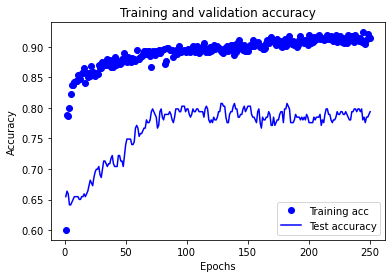

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Getting model weights

Here we show how weights for a layer can be extracted from the model if required.

In [18]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [19]:
weights, biases = hidden1.get_weights() # Biases are not used in this model
weights.shape

(24, 240)

In [20]:
weights

array([[-0.12919429, -0.13312374,  0.06985242, ..., -0.07173613,
         0.08528158, -0.10930091],
       [ 0.00096841, -0.00203114, -0.16541865, ...,  0.05610456,
         0.01142883, -0.06329967],
       [-0.07471476, -0.03558683,  0.13795292, ...,  0.26371986,
        -0.11758574,  0.1759898 ],
       ...,
       [ 0.01436587, -0.05248635,  0.12524982, ..., -0.02291065,
         0.1610094 ,  0.12106831],
       [-0.03732884,  0.06372197,  0.11742309, ..., -0.01034255,
        -0.02890154, -0.1229093 ],
       [-0.11988714, -0.04239187,  0.01223355, ..., -0.14704905,
        -0.03315052,  0.0113337 ]], dtype=float32)

## Evaluating model

If a test set is not used to evaluate in training, or if there is an independnent test set, evaluation may be quickly performed using the `evaluate` method.

In [21]:
model_2.evaluate(X_test_sc, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.5584 - accuracy: 0.7937


[0.5584115982055664, 0.7937219738960266]